## Visualize platemap design

Each platemap is setup differently to measure different NF1 genotypes, and the cell count is different per well.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(platetools))

In [2]:
# Set directories
output_dir <- "platemap_figures"

input_platemap_dir <- file.path(
    "..", 
    "CellProfiler_pipelines",
    "Metadata"
)

input_feature_dir <- file.path(
    "..",
    "4_processing_features",
    "data"
)

plates <- c(
    "plate_1" = "platemap_NF1_CP.csv",
    "plate_2" = "platemap_NF1_CP_Plate2.csv"
)

# Corresponding to feature directory per plate
plate_feature_dir <- c(
    "plate_1" = "Plate1",
    "plate_2" = "Plate2"
)

plates

plate_1                      plate_2 
       "platemap_NF1_CP.csv" "platemap_NF1_CP_Plate2.csv"

## Load platemap files

In [3]:
platemap_dfs <- list()
for (platemap in names(plates)) {
    platemap_file <- file.path(
        input_platemap_dir,
        plates[[platemap]]
    )
    
    platemap_dfs[[platemap]] <- readr::read_csv(
        platemap_file,
        col_types = readr::cols(
            .default = "c"
        )
    )
    
    print(platemap)
    print(dim(platemap_dfs[[platemap]]))
}

[1] "plate_1"
[1] 8 5
[1] "plate_2"
[1] 32  5


## Load cell count files per plate

In [4]:
cell_count_platemaps <- list()
for (plate in names(plates)) {
    plate_dir <- plate_feature_dir[[plate]]
    
    feature_file <- file.path(
        input_feature_dir,
        plate_dir,
        "CellProfiler",
        "nf1_sc_norm_fs_cellprofiler.csv.gz"
    )
    
    # Currently, plate 2 cell count does not exist in main
    # Skip for now
    if (plate == "plate_2") {
        cell_count_platemaps[[plate]] <- platemap_dfs[[plate]]
        break
    }
    
    # Update the platemap to contain cell counts
    cell_count_platemaps[[plate]] <- readr::read_csv(
        feature_file,
        col_types = readr::cols(
            .default = "c"
        )
    ) %>%
        dplyr::group_by(Metadata_Well) %>%
        dplyr::count() %>%
        dplyr::full_join(platemap_dfs[[plate]], by = c("Metadata_Well" = "well_position")) %>%
        dplyr::rename(cell_count = n, well_position = Metadata_Well) %>%
        dplyr::ungroup()
}

## Visualize platemaps

Warning message:
“Warning: Your well label count ( 8 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”
Warning message:
“Warning: Your well label count ( 8 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”
Warning message:
“Warning: Your well label count ( 32 ) covers less than half the selected plate( 96 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


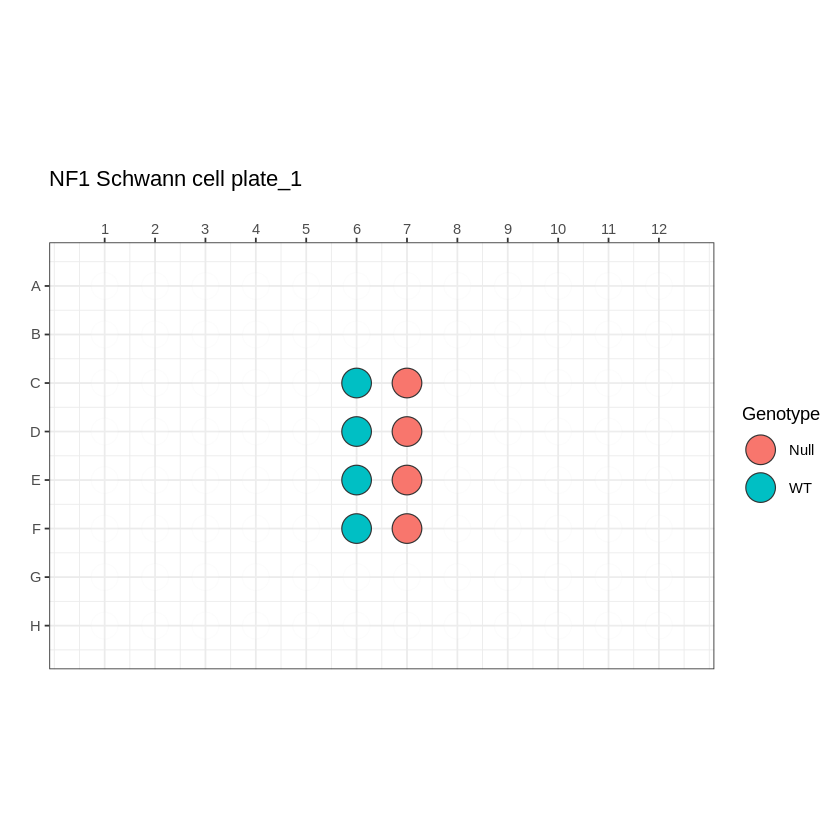

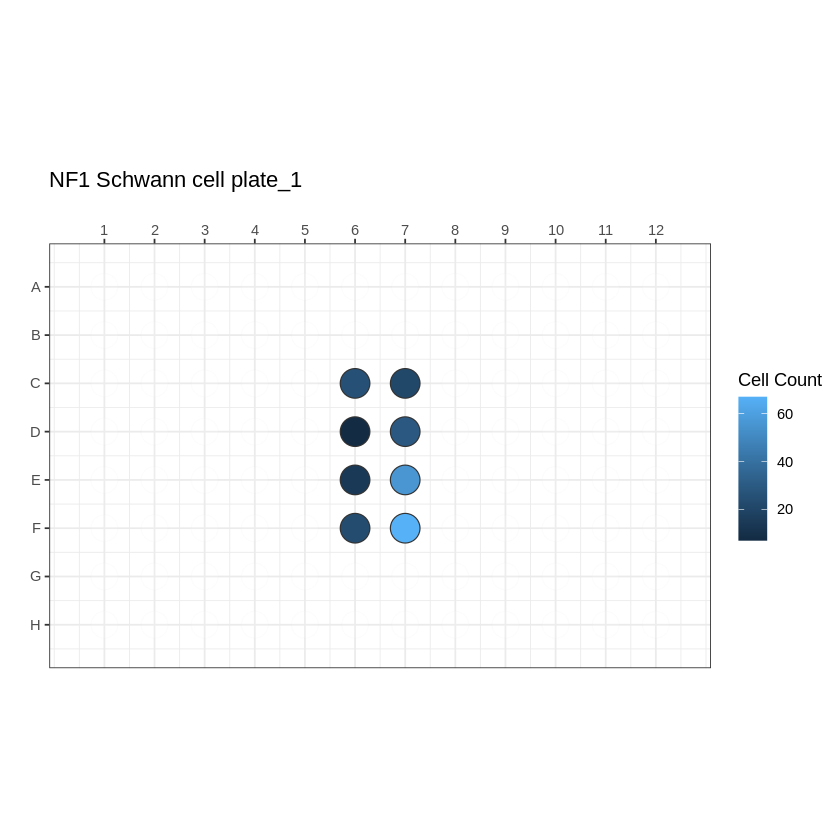

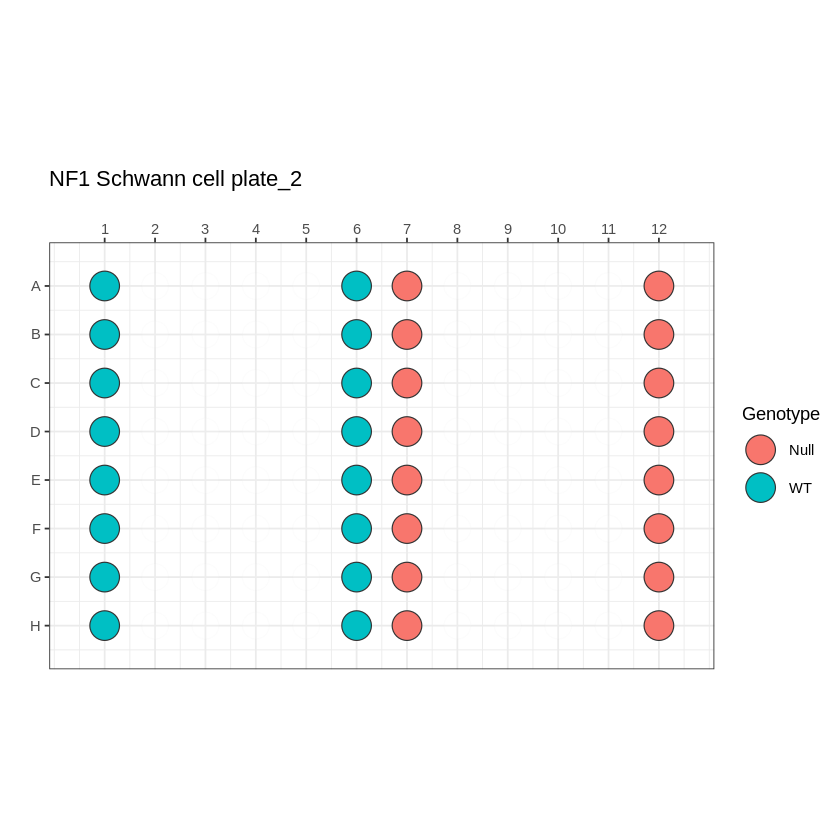

In [5]:
for (plate in names(plates)) {
    output_fig_genotype <- file.path(
        output_dir,
        paste0("genotype_platemap_", plate, ".png")
    )
    
    plate_replicate_gg <- (
        platetools::raw_map(
            data = cell_count_platemaps[[plate]]$genotype,
            well = cell_count_platemaps[[plate]]$well_position,
            plate = 96,
            size = 8
        )
        + scale_fill_discrete(name="Genotype")
        + ggtitle(paste("NF1 Schwann cell", plate))
    )
    
    
    ggsave(
        output_fig_genotype,
        plate_replicate_gg,
        dpi = 500,
        height = 3.5,
        width = 6
    )

    print(plate_replicate_gg)
    
    # Plate 1 contains cell counts, add here while only 1 plate has counts
    if (plate == "plate_1") {
        output_fig_genotype <- file.path(
            output_dir,
            paste0("cell_count_platemap_", plate, ".png")
        )

        cell_count_gg <- (
            platetools::raw_map(
                data = cell_count_platemaps[[plate]]$cell_count,
                well = cell_count_platemaps[[plate]]$well_position,
                plate = 96,
                size = 8
            )
            + scale_fill_continuous(name="Cell Count")
            + ggtitle(paste("NF1 Schwann cell", plate))
        )
        
        ggsave(
            output_fig_genotype,
            cell_count_gg,
            dpi = 500,
            height = 3.5,
            width = 6
        )
        
        print(cell_count_gg)
    }
}